[課題のURL](https://diver.diveintocode.jp/curriculums/1877)

# Sprint 深層学習スクラッチ ディープニューラルネットワーク

In [1]:
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

* データセットをダウンロード

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
#print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)


* 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

* 前処理

画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。

In [7]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。  
scikit-learnのOneHotEncoderを使用したコードが以下です。  
このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。  

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


さらに、訓練データ6万枚の内2割を検証データとして分割してください。  
訓練データが48000枚、検証データが12000枚となります。  

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [10]:
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [11]:
y_train

array([9, 4, 0, ..., 7, 9, 0], dtype=uint8)

In [12]:
print(y_train_one_hot[0])
print(y_train_one_hot[1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


# ディープニューラルネットワークスクラッチ

今回はこれを任意の層数に拡張しやすいものに書き換えていきます。  
その上で、活性化関数や初期値、最適化手法について発展的なものを扱えるようにしていきます。  

* ミニバッチ処理

ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。  
分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。  

In [13]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([0, 3, 1, 3, 8, 2, 1, 7, 1, 2, 6, 0, 3, 5, 6, 4, 9, 0, 6, 1],
      dtype=uint8))


# 【問題1】全結合層のクラス化

~~~
    class FC:
        def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
            self.optimizer = optimizer
            
            self.W = initializer.W(n_nodes1, n_nodes2)
            self.B = initializer.B(n_nodes1, n_nodes2)
            self.x = None
            self.dw = None
            self.db = None
            
        def forward(self, x):
            self.x = x
            return (np.dot(x, self.W) + self.B )

        def backward(self, dout):
            dw = np.dot((self.x).T, dout)
            db = np.sum(dout, axis=0)
            
            # パラメータを更新
            self = self.optimizer.update(self, dw, db)
            
            # 前の層に渡す
            dZ = np.dot(dout, (self.W).T)
            
            return dZ
~~~

# 【問題2】初期化方法のクラス化

~~~
    class SimpleInitializer:
        def __init__(self, sigma):
            self.sigma = sigma
        def W(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
            return W
        
        def B(self, n_nodes1, n_nodes2):
            # n_nodes2は使用しないが、他の初期化関数とIFを合わせる
            np.random.seed(1)
            b = self.sigma * np.random.randn(n_nodes2)
            return b
~~~

# 【問題3】最適化手法のクラス化

~~~
    class SGD:
        def __init__(self, lr):
            self.lr = lr
        def update(self, layer, dw, db):
            layer.W = layer.W - self.lr*dw
            layer.B = layer.B - self.lr*db
            
            return layer
~~~

# 【問題4】活性化関数のクラス化

~~~
    class sigmoid:
        def __init__(self):
            self.out = None
        
        def _sigmoid(self, x):
            sigmoid_range = 34.538776394910684
            x = np.clip(x, -sigmoid_range, sigmoid_range)
            return 1.0/(1.0+np.exp(-x))
        
        def forward(self, x):
            y = self._sigmoid(x)
            self.out = y
            
            return y

        def backward(self, dz):
            dA = dz*(1 - self.out)*(self.out)
            
            return dA
    
    class activation_softmax:
        def __init__(self):
            self.y = None
            self.t = None # one-hot
            
        def _softmax(self, x):
            n = x.shape[0]

            for i in range(n):
                exp_x = np.exp(x[i])
                sum_exp_x = np.sum(exp_x)
                x[i] = exp_x/sum_exp_x

            return x
        
        def forward(self, x):
            self.y = self._softmax(x)
            
            return self.y

        def backward(self, z, t):
            d = z - t
            
            return d
~~~

# 【問題5】ReLUクラスの作成

~~~
class ReLU():
    
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        x_out = x.copy()
        x_out[self.mask] = 0
        
        return x_out
        
    def backward(self, x):
        x[self.mask] = 0
        dx = x
        
        return dx
~~~

# 【問題6】重みの初期値

ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。  
しかし、どのような値にすると良いかが知られています。  
シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。  

XavierInitializerクラスと、HeInitializerクラスを作成してください。  

* XavierInitializerクラス

~~~
class XavierInitializer:
    def __init_(self):
        # 何もしない
        pass
    
    def W(self, n_nodes1, n_nodes2):
        W = (1/np.sqrt(n_nodes1)) * np.random.randn(n_nodes1, n_nodes2)
        return W
        
    def B(self, n_nodes1, n_nodes2):
        np.random.seed(1)
        b = (1/np.sqrt(n_nodes1)) * np.random.randn(n_nodes2)
        return b
~~~

* HeInitializerクラス

~~~
class HeInitializer:
    def __init_(self):
        # 何もしない
        pass

    def W(self, n_nodes1, n_nodes2):
        W = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
        return W

    def B(self, n_nodes1, n_nodes2):
        np.random.seed(1)
        b = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes2)
        return b
~~~

# 【問題7】最適化手法

学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。

~~~
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.hw = None
        self.hb = None
        
    def update(self, layer, dw, db):
        if (self.hw is None) or (self.hb is None):
            self.hw = np.zeros_like(dw)
            self.hb = np.zeros_like(db)
        
        self.hw = self.h + (dw*dw)
        layer.W = layer.W - self.lr*dw/(np.sqrt(self.hw) + 1e-7)
        
        self.wb = self.wb + (db*db)
        layer.B = layer.B - self.lr*db/(np.sqrt(self.hb) + 1e-7)
         
        return layer
~~~

# 【問題8】クラスの完成

In [181]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    N層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, epoch = 5, alpha = 0.001, activation='sigmoid', optimizer="SGD", init="simple" ,verbose = True):
        self.verbose = verbose
        
        self.epoch = epoch
        self.batch_size = 20 # バッチサイズ
        
        self.n_features = 784 # 特徴量の数
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_nodes3 = 100
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        
        self.init_type = init # 初期化方法
        self.activation_type = activation # 活性化関数
        self.optimizer_type = optimizer # 最適化方法
        
        self.sigma = 1 # ガウス分布の標準偏差
        self.lr = alpha

    def _encode_10(self, data):
        t = np.zeros((data.size, 10))
        for i in range(data.size):
            t[i, data[i]] = 1
        return t

    def _calc_loss(self, y, z):
        # エントロピー誤差を求める
        # 0割回避のため(z=0を防ぐため)
        delta = 1e-7
        n = y.shape[0]

        l = -1/n*np.sum(y*np.log(z+delta))

        return l
    
    class sigmoid:
        def __init__(self):
            self.out = None
        
        def _sigmoid(self, x):
            sigmoid_range = 34.538776394910684
            x = np.clip(x, -sigmoid_range, sigmoid_range)
            return 1.0/(1.0+np.exp(-x))
        
        def forward(self, x):
            y = self._sigmoid(x)
            self.out = y
            
            return y

        def backward(self, dz):
            dA = dz*(1 - self.out)*(self.out)
            
            return dA
    
    class ReLU:
        def __init__(self):
            self.mask = None

        def forward(self, x):
            self.mask = (x <= 0)
            x_out = x.copy()
            x_out[self.mask] = 0

            return x_out

        def backward(self, x):
            x[self.mask] = 0
            dx = x

            return dx
    
    class activation_softmax:
        def __init__(self):
            self.y = None
            self.t = None # one-hot
            
        def _softmax(self, x):
            n = x.shape[0]

            sigmoid_range = 34.538776394910684
            x = np.clip(x, -sigmoid_range, sigmoid_range)
            
            for i in range(n):
                exp_x = np.exp(x[i])
                sum_exp_x = np.sum(exp_x)
                x[i] = exp_x/sum_exp_x

            return x
        
        def forward(self, x):
            self.y = self._softmax(x)
            
            return self.y

        def backward(self, z, t):
            d = z - t
            
            return d
    
    class SimpleInitializer:
        def __init__(self, sigma):
            self.sigma = sigma
        def W(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
            return W
        
        def B(self, n_nodes1, n_nodes2):
            # n_nodes2は使用しないが、他の初期化関数とIFを合わせる
            np.random.seed(1)
            b = self.sigma * np.random.randn(n_nodes2)
            return b

    class XavierInitializer:
        def __init_(self):
        # 何もしない
            pass
    
        def W(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            W = (1/np.sqrt(n_nodes1)) * np.random.randn(n_nodes1, n_nodes2)
            return W
        
        def B(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            b = (1/np.sqrt(n_nodes1)) * np.random.randn(n_nodes2)
            return b
    
    class HeInitializer:
        def __init_(self):
            # 何もしない
            pass

        def W(self, n_nodes1, n_nodes2):
            W = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes1, n_nodes2)
            return W

        def B(self, n_nodes1, n_nodes2):
            np.random.seed(1)
            b = np.sqrt(2/n_nodes1) * np.random.randn(n_nodes2)
            return b
    
    class SGD:
        def __init__(self, lr=0.01):
            self.lr = lr
        def update(self, layer, dw, db):
            layer.W = layer.W - self.lr*dw
            layer.B = layer.B - self.lr*db
            
            return layer
    
    class AdaGrad:
        def __init__(self, lr=0.01):
            self.lr = lr
            self.hw = None
            self.hb = None

        def update(self, layer, dw, db):
            if (self.hw is None) or (self.hb is None):
                self.hw = np.zeros_like(dw)
                self.hb = np.zeros_like(db)

            self.hw = self.hw + (dw*dw)
            layer.W = layer.W - self.lr*dw/(np.sqrt(self.hw) + 1e-7)

            self.hb = self.hb + (db*db)
            layer.B = layer.B - self.lr*db/(np.sqrt(self.hb) + 1e-7)
         
            return layer
    
    class FC:
        def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
            self.optimizer = optimizer
            
            self.W = initializer.W(n_nodes1, n_nodes2)
            self.B = initializer.B(n_nodes1, n_nodes2)
            self.x = None
            self.dw = None
            self.db = None
            
        def forward(self, x):
            self.x = x
            return (np.dot(x, self.W) + self.B )

        def backward(self, dout):
            dw = np.dot((self.x).T, dout)
            db = np.sum(dout, axis=0)
            
            # パラメータを更新
            self = self.optimizer.update(self, dw, db)
            
            # 前の層に渡す
            dZ = np.dot(dout, (self.W).T)
            
            return dZ

    def fit(self, X, y, X_val=None, y_val=None):
        # 検証データ(X_val, y_val)の有無を確認
        flag_val = True
        if (X_val is None) and (y_val is None):
            # 検証データが入力されなかった場合、検証データの保存と学習過程を表示しない
            flag_val = False

        # self.sigma : ガウス分布の標準偏差
        # self.lr : 学習率
        # self.n_nodes1 : 1層目のノード数
        # self.n_nodes2 : 2層目のノード数
        # self.n_output : 出力層のノード数
        sigma = self.sigma
        alpha = self.lr
        epoch = self.epoch
        batch_size = self.batch_size
        
        # 初期化
        score = np.zeros(epoch)
        accuracy = np.zeros(epoch)
        score_val = np.zeros(epoch)
        accuracy_val = np.zeros(epoch)
        
        # 初期化関数, 活性化関数、最適化手法の設定
        # 初期化方法
        # func_init = self.SimpleInitializer(sigma)
        # func_init = self.XavierInitializer()
        # func_init = self.HeInitializer()
        
        # 活性化関数
        # activation = self.sigmoid()
        # activation = self.ReLU()
        # activation = self.sigmoid()
        
        # 最適化方法
        # optimizer = self.SGD(alpha)
        # optimizer = self.AdaGrad(alpha)
        
        # ノード設定
        self.FC1 = self.FC(self.n_features, self.n_nodes1, self.HeInitializer(), self.AdaGrad(alpha))
        self.activation1 = self.ReLU()
        
        self.FC2 = self.FC(self.n_nodes1, self.n_nodes2, self.HeInitializer(), self.AdaGrad(alpha))
        self.activation2 = self.ReLU()
        
        self.FC3 = self.FC(self.n_nodes2, self.n_nodes3, self.HeInitializer(), self.AdaGrad(alpha))
        self.activation3 = self.ReLU()
        
        self.FC4 = self.FC(self.n_nodes3, self.n_output, self.HeInitializer(), self.AdaGrad(alpha))
        self.activation4 = self.activation_softmax()
        
        for count_epoch in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size, seed=epoch)

            # @@@debug
            start = time.time()
            
            # 1 epoch
            for mini_X_train, mini_y_train in get_mini_batch:
                mini_y_train_one_hot = self._encode_10(mini_y_train)
                
                # イテレーションごとのフォワード
                A1 = self.FC1.forward(mini_X_train) 
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)                
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                Z3 = self.activation3.forward(A3)
                A4 = self.FC4.forward(Z3)
                Z4 = self.activation4.forward(A4)
                
                dA4 = self.activation4.backward(Z4, mini_y_train_one_hot)
                dZ3 = self.FC4.backward(dA4)
                dA3 = self.activation3.backward(dZ3)
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しないがw,bの更新で利用
            
            # エポックごとの損失
            y_pred, y_pred_portion = self.predict(X)
            
            # 交差エントロピー誤差(1 epoch)
            score[count_epoch] = self._calc_loss(self._encode_10(y), y_pred_portion)
            
            # 正解率
            accuracy[count_epoch] = accuracy_score(y_pred, y)
            
            if flag_val == True:
                y_pred_val, y_pred_val_portion = self.predict(X_val)
                score_val[count_epoch] = self._calc_loss(self._encode_10(y_val), y_pred_val_portion)
                accuracy_val[count_epoch] = accuracy_score(y_pred_val, y_val)

            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                # @@@debug
                elapsed_time = time.time() - start
                print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
                
                if flag_val == True:
                    print("epoch:",(count_epoch+1),"accuracy:",accuracy[count_epoch], "loss:", score[count_epoch])
                    print("epoch:",(count_epoch+1),"accuracy_val:",accuracy_val[count_epoch], "loss_val:", score_val[count_epoch])
                else:
                    print("epoch:",(count_epoch+1),"accuracy:",accuracy[count_epoch], "loss:", score[count_epoch])
        
            # 学習データの保存
            self._score = score
            self._accuracy = accuracy
            self._score_val = score_val
            self._accuracy_val = accuracy_val
        
        return

    def predict(self, X):
        # イテレーションごとのフォワード
        A1 = self.FC1.forward(X) 
        Z1 = self.activation1.forward(A1)
                
        A2 = self.FC2.forward(Z1)                
        Z2 = self.activation2.forward(A2)
                
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        
        portion = Z4
        label = np.argmax(portion, axis = 1)
        
        return label, portion

In [178]:
clf_test = ScratchDeepNeuralNetrowkClassifier(epoch = 1, alpha = 0.01, activation='sigmoid', optimizer="SGD", init="simple", verbose = True)
clf_test.fit(X_train, y_train, X_val, y_val)

elapsed_time:36.21893882751465[sec]
epoch: 1 accuracy: 0.8717916666666666 loss: 0.588490303453302
epoch: 1 accuracy_val: 0.8673333333333333 loss_val: 0.5906639542416382


In [179]:
y_pred, y_pred_portion = clf_test.predict(X_test)

print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.8759


# 【問題9】学習と推定

層の数や活性化関数を変えたいくつかのネットワークを作成してください。  
そして、MNISTのデータを学習・推定し、Accuracyを計算してください。  

* 3層(784, 400, 200)  epoch = 20  
  
No1, activation='sigmoid', optimizer="SGD", init="simple"  alpha = 0.01, Accuracy（正解率） 0.9351 
  
No2, activation='sigmoid', optimizer="SGD", init="XavierInitializer"  alpha = 0.001, Accuracy（正解率） 0.9334  
→No1から初期化の方法を"XavierInitializer"に変更した。また、alpha = 0.001にした場合、収束しなかったため、alpha = 0.01に変更。  
No1と正解率に差異はなかったが、No2は過学習をしていないことがわかった。  
初期化の方法などを変えた場合は、alphaの方法も見直す必要あり?  
  
No3, activation='ReLU', optimizer="ReLU", init="HeInitializer", alpah = 0.001, Accuracy（正解率） 0.9672  
→No2、からactivation='ReLU', init="HeInitializer"に変更した。正解率が改善された。 

No4, activation='ReLU', optimizer="ReLU", init="HeInitializer", alpah = 0.01, Accuracy（正解率） 0.9584  
→No3、からoptimizer="AdaGrad"に変更した。alpha = 0.001で実施したが精度がでなかったのでalpah = 0.01に変更した。  
→alphaが小さすぎ? そもそも、epochが少なすぎ?

* 4層(784, 400, 200, 100) epoch = 20
No5, activation='ReLU', optimizer="ReLU", init="HeInitializer", alpah = 0.001, Accuracy（正解率） 0.9668
→NO4, からノード数とalphaを変更した。No4からノード数を増やしたので精度が向上した?


In [131]:
clf_test = ScratchDeepNeuralNetrowkClassifier(epoch = 20, alpha = 0.01, activation='sigmoid', optimizer="SGD", init="simple", verbose = True)
clf_test.fit(X_train, y_train, X_val, y_val)

elapsed_time:22.71927285194397[sec]
epoch: 1 accuracy: 0.8894375 loss: 0.3734581055556131
epoch: 1 accuracy_val: 0.8768333333333334 loss_val: 0.4273989618900114
elapsed_time:28.453667879104614[sec]
epoch: 2 accuracy: 0.9195625 loss: 0.2618067039345965
epoch: 2 accuracy_val: 0.8995833333333333 loss_val: 0.34219123920102096
elapsed_time:27.290560007095337[sec]
epoch: 3 accuracy: 0.9334166666666667 loss: 0.2118208368514956
epoch: 3 accuracy_val: 0.9084166666666667 loss_val: 0.3124532712973039
elapsed_time:23.686200618743896[sec]
epoch: 4 accuracy: 0.9434791666666666 loss: 0.17848418166029162
epoch: 4 accuracy_val: 0.9160833333333334 loss_val: 0.29522965694681125
elapsed_time:23.819780826568604[sec]
epoch: 5 accuracy: 0.9489791666666667 loss: 0.15714946209506836
epoch: 5 accuracy_val: 0.9173333333333333 loss_val: 0.2867447487579595
elapsed_time:24.782721042633057[sec]
epoch: 6 accuracy: 0.9558125 loss: 0.1356623124656966
epoch: 6 accuracy_val: 0.92025 loss_val: 0.2780547871380823
elapsed_t

In [134]:
y_pred, y_pred_portion = clf_test.predict(X_test)
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9351


オレンジ:X_val, 青:X_train


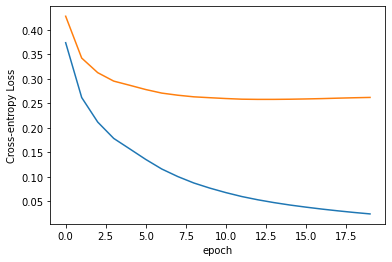

In [132]:
plt.plot(clf_test._score)
plt.plot(clf_test._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


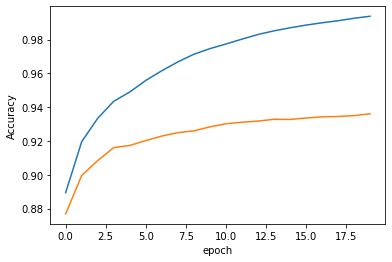

In [133]:
plt.plot(clf_test._accuracy)
plt.plot(clf_test._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

In [142]:
clf_test1 = ScratchDeepNeuralNetrowkClassifier(epoch = 20, alpha = 0.001, activation='sigmoid', optimizer="SGD", init="XavierInitializer", verbose = True)
clf_test1.fit(X_train, y_train, X_val, y_val)

elapsed_time:23.690749883651733[sec]
epoch: 1 accuracy: 0.7378541666666667 loss: 1.0653870635185831
epoch: 1 accuracy_val: 0.73775 loss_val: 1.0702585572013552
elapsed_time:23.663273811340332[sec]
epoch: 2 accuracy: 0.85175 loss: 0.5556354265283907
epoch: 2 accuracy_val: 0.8490833333333333 loss_val: 0.5587083757287458
elapsed_time:22.887027978897095[sec]
epoch: 3 accuracy: 0.8807916666666666 loss: 0.42743327040107504
epoch: 3 accuracy_val: 0.8825 loss_val: 0.42878585391800633
elapsed_time:22.524601936340332[sec]
epoch: 4 accuracy: 0.893 loss: 0.3763587448979041
epoch: 4 accuracy_val: 0.8945833333333333 loss_val: 0.3771638286877785
elapsed_time:22.90741515159607[sec]
epoch: 5 accuracy: 0.9002291666666666 loss: 0.3483700024933593
epoch: 5 accuracy_val: 0.902 loss_val: 0.34932580873063657
elapsed_time:22.959046125411987[sec]
epoch: 6 accuracy: 0.9052916666666667 loss: 0.32931038566352805
epoch: 6 accuracy_val: 0.9065 loss_val: 0.33077095759679753
elapsed_time:23.109108924865723[sec]
epoch

In [146]:
y_pred, y_pred_portion = clf_test1.predict(X_test)
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9334


オレンジ:X_val, 青:X_train


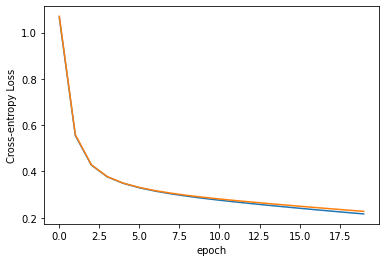

In [147]:
plt.plot(clf_test1._score)
plt.plot(clf_test1._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


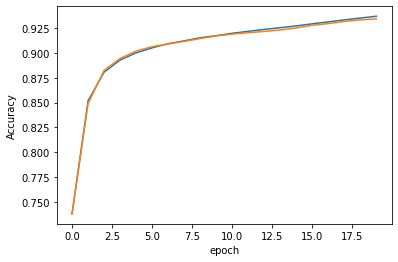

In [148]:
plt.plot(clf_test1._accuracy)
plt.plot(clf_test1._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

In [164]:
clf_test2 = ScratchDeepNeuralNetrowkClassifier(epoch = 20, alpha = 0.01, activation='ReLU', optimizer="SGD", init="HeInitializer", verbose = True)
clf_test2.fit(X_train, y_train, X_val, y_val)

elapsed_time:37.32060885429382[sec]
epoch: 1 accuracy: 0.926375 loss: 0.2546342915835059
epoch: 1 accuracy_val: 0.9264166666666667 loss_val: 0.2597644049550845
elapsed_time:37.266287088394165[sec]
epoch: 2 accuracy: 0.9370625 loss: 0.21474091251952532
epoch: 2 accuracy_val: 0.9363333333333334 loss_val: 0.22359613211623564
elapsed_time:36.50170016288757[sec]
epoch: 3 accuracy: 0.9437708333333333 loss: 0.19177395286113746
epoch: 3 accuracy_val: 0.9418333333333333 loss_val: 0.20338624369954905
elapsed_time:36.33437490463257[sec]
epoch: 4 accuracy: 0.9487916666666667 loss: 0.17529159435901587
epoch: 4 accuracy_val: 0.9463333333333334 loss_val: 0.18909403042981704
elapsed_time:36.42819809913635[sec]
epoch: 5 accuracy: 0.952625 loss: 0.16238784345110982
epoch: 5 accuracy_val: 0.9489166666666666 loss_val: 0.17798453838710573
elapsed_time:35.7667179107666[sec]
epoch: 6 accuracy: 0.9553958333333333 loss: 0.15183439910654756
epoch: 6 accuracy_val: 0.9515 loss_val: 0.16896372237607246
elapsed_tim

In [165]:
y_pred, y_pred_portion = clf_test2.predict(X_test)
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9672


オレンジ:X_val, 青:X_train


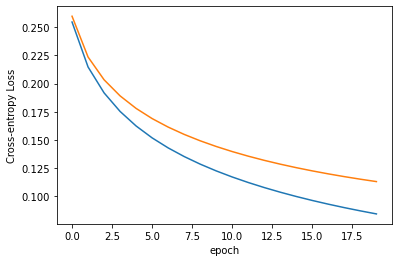

In [166]:
plt.plot(clf_test2._score)
plt.plot(clf_test2._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


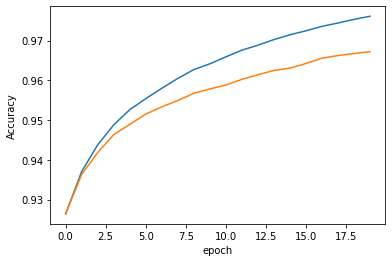

In [167]:
plt.plot(clf_test2._accuracy)
plt.plot(clf_test2._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy"
# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

In [169]:
clf_test3 = ScratchDeepNeuralNetrowkClassifier(epoch = 20, alpha = 0.01, activation='ReLU', optimizer="AdaGrad", init="HeInitializer", verbose = True)
clf_test3.fit(X_train, y_train, X_val, y_val)

elapsed_time:34.37991213798523[sec]
epoch: 1 accuracy: 0.926375 loss: 0.2627931902930804
epoch: 1 accuracy_val: 0.9235833333333333 loss_val: 0.2718944756400574
elapsed_time:33.96354007720947[sec]
epoch: 2 accuracy: 0.9373958333333333 loss: 0.22373999052829968
epoch: 2 accuracy_val: 0.9333333333333333 loss_val: 0.23837877449992004
elapsed_time:33.288159132003784[sec]
epoch: 3 accuracy: 0.944375 loss: 0.1971622050704699
epoch: 3 accuracy_val: 0.9401666666666667 loss_val: 0.21556246299456355
elapsed_time:33.3585569858551[sec]
epoch: 4 accuracy: 0.9496666666666667 loss: 0.17770059768409924
epoch: 4 accuracy_val: 0.9449166666666666 loss_val: 0.19867404648505285
elapsed_time:33.56186103820801[sec]
epoch: 5 accuracy: 0.9540833333333333 loss: 0.16405318615803913
epoch: 5 accuracy_val: 0.94875 loss_val: 0.186891018305195
elapsed_time:35.484336137771606[sec]
epoch: 6 accuracy: 0.9565 loss: 0.15353512513641981
epoch: 6 accuracy_val: 0.952 loss_val: 0.17816492672905296
elapsed_time:37.527447700500

In [170]:
y_pred, y_pred_portion = clf_test3.predict(X_test)
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9584


オレンジ:X_val, 青:X_train


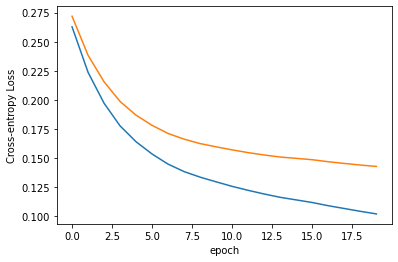

In [171]:
plt.plot(clf_test3._score)
plt.plot(clf_test3._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


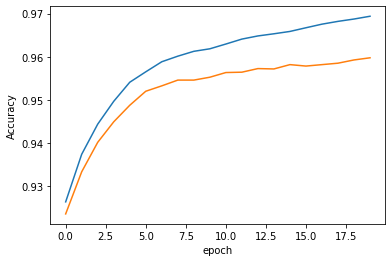

In [172]:
plt.plot(clf_test3._accuracy)
plt.plot(clf_test3._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

In [183]:
clf_test4 = ScratchDeepNeuralNetrowkClassifier(epoch = 20, alpha = 0.001, activation='ReLU', optimizer="AdaGrad", init="HeInitializer", verbose = True)
clf_test4.fit(X_train, y_train, X_val, y_val)

elapsed_time:36.02968978881836[sec]
epoch: 1 accuracy: 0.931875 loss: 0.2451563714728658
epoch: 1 accuracy_val: 0.9313333333333333 loss_val: 0.2530102335253839
elapsed_time:36.43267321586609[sec]
epoch: 2 accuracy: 0.9422291666666667 loss: 0.2050995680788994
epoch: 2 accuracy_val: 0.9399166666666666 loss_val: 0.2163911916983263
elapsed_time:36.4906542301178[sec]
epoch: 3 accuracy: 0.9480208333333333 loss: 0.18349168979441635
epoch: 3 accuracy_val: 0.9450833333333334 loss_val: 0.19721726444266247
elapsed_time:36.86022996902466[sec]
epoch: 4 accuracy: 0.9519791666666667 loss: 0.16878595718523867
epoch: 4 accuracy_val: 0.9485833333333333 loss_val: 0.18445264869347974
elapsed_time:36.69039177894592[sec]
epoch: 5 accuracy: 0.955 loss: 0.15768369115113234
epoch: 5 accuracy_val: 0.95125 loss_val: 0.1749612632532014
elapsed_time:36.23253870010376[sec]
epoch: 6 accuracy: 0.9576041666666667 loss: 0.14883473840725428
epoch: 6 accuracy_val: 0.953 loss_val: 0.16750766681641202
elapsed_time:36.34147

In [184]:
y_pred, y_pred_portion = clf_test4.predict(X_test)
print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9668


オレンジ:X_val, 青:X_train


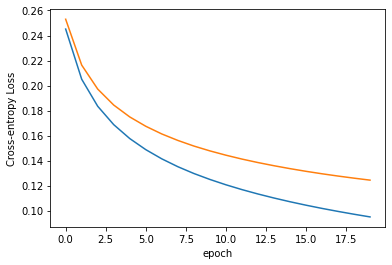

In [185]:
plt.plot(clf_test4._score)
plt.plot(clf_test4._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


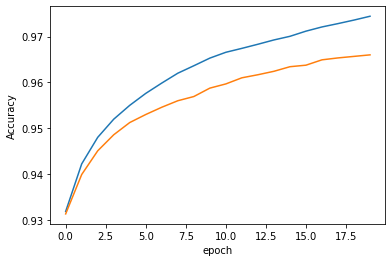

In [186]:
plt.plot(clf_test4._accuracy)
plt.plot(clf_test4._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()